In [1]:
# 1. 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


-------

-------

# 1. Median Filter

In [2]:
import os
import glob
import pandas as pd

# 你会用到的数值通道（存在才滤）。FreeAcc_* 视你是否要用而定。
PRIMARY_SIGNALS = [
    "Acc_X", "Acc_Y", "Acc_Z",
    "Gyr_X", "Gyr_Y", "Gyr_Z",
    "FreeAcc_E", "FreeAcc_N", "FreeAcc_U",]

def median_filter(
    cleaned_folder="/content/drive/My Drive/final_project/augmentation/cleaned",
    output_folder="/content/drive/My Drive/final_project/augmentation/medianfilter",
    kernel_size=3,
    return_dict=True
):
    """
    对 cleaned_folder 里的 CSV 做中值滤波（窗口=kernel_size，默认3点），
    只处理存在于 PRIMARY_SIGNALS 的列；结果写入 output_folder。
    """
    assert kernel_size % 2 == 1, "kernel_size 必须为奇数"
    os.makedirs(output_folder, exist_ok=True)

    filtered_data = {} if return_dict else None
    files = sorted(glob.glob(os.path.join(cleaned_folder, "*.csv")))

    for fp in files:
        df = pd.read_csv(fp)

        # 找出当前文件里实际存在且需要滤波的列
        cols_to_filter = [c for c in PRIMARY_SIGNALS if c in df.columns]

        # 中值滤波（滚动窗口，中心对齐；边界用实际点数，不做零填充）
        for col in cols_to_filter:
            s = pd.to_numeric(df[col], errors="coerce")
            df[col] = (
                s.rolling(window=kernel_size, center=True, min_periods=1)
                 .median()
                 .astype(float)
            )

        # 不要对 Quat/Euler/标签/计数器做滤波（保持原样）
        # 如果你真的要滤四元数，必须在这里加一步单位化：q = q / ||q||

        # 写回
        filename = os.path.basename(fp)
        out_path = os.path.join(output_folder, filename)
        df.to_csv(out_path, index=False)
        print(f"[saved] {out_path}")

        if return_dict:
            filtered_data[filename.replace(".csv", "")] = df

    return filtered_data

# 运行
filtered_data_dict = median_filter(
    output_folder="/content/drive/My Drive/final_project/augmentation/medianfilter"
)


[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT0_ankle.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT0_wrist.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT1_ankle.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT1_wrist.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT2_ankle.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT2_wrist.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT3_ankle.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT3_wrist.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT4_ankle.csv
[saved] /content/drive/My Drive/final_project/augmentation/medianfilter/T11_M10_WT4_wrist.csv
[saved] /content/drive/My Drive/final_project/augmentation/m

In [3]:
filtered_data_dict

{'T11_M10_WT0_ankle':          Acc_X     Acc_Y     Acc_Z  FreeAcc_E  FreeAcc_N  FreeAcc_U     Gyr_X  \
 0     1.552922  9.673808 -1.290903  -0.005357   0.003686   0.069647 -0.001756   
 1     1.557896  9.671388 -1.280055  -0.016881   0.001207   0.067920 -0.001400   
 2     1.551941  9.652690 -1.298117   0.000716   0.000614   0.048513 -0.001400   
 3     1.551941  9.652690 -1.298117   0.000716   0.001207   0.048513 -0.001557   
 4     1.534013  9.673602 -1.298117   0.000716   0.002288   0.063518 -0.003201   
 ...        ...       ...       ...        ...        ...        ...       ...   
 2211  0.955272  9.818328 -0.978958   0.056813   0.187227   0.097461  0.120099   
 2212  0.955272  9.761436 -1.039333   0.008652   0.210952   0.053384  0.116985   
 2213  1.069702  9.743563 -1.115152  -0.003864   0.312548   0.048032  0.091267   
 2214  1.069702  9.709308 -1.160449  -0.028392   0.312548   0.013846  0.073818   
 2215  1.052208  9.692997 -1.139928  -0.036474   0.303401  -0.001104  0.05984

### 画一张 raw vs median(3) 的对比（Acc_X/Gyr_X 各来一条），肉眼看就知道滤得是否“温和且去尖噪”。

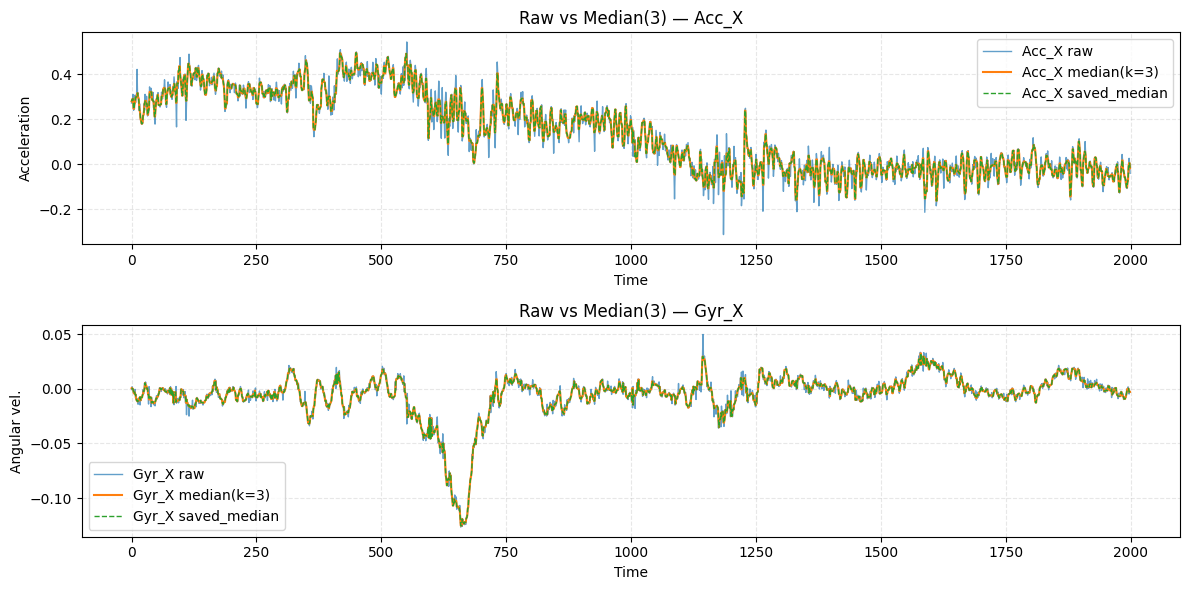

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

def plot_raw_vs_median(
    raw_csv: str,
    filtered_csv: Optional[str] = None,   # 可选：如果你已经落盘了滤波结果，传入它做对照
    acc_col: str = "Acc_X",
    gyr_col: str = "Gyr_X",
    time_col: str = "PacketTime_ms",
    # time_col: Optional[str] = None,       # 可选：时间戳列名（如无就用样本索引）
    kernel_size: int = 3,
    window: Optional[Tuple[int,int]] = None,  # 可选：指定 [start, end) 样本区间放大查看
):
    """
    在同一图里叠加 raw vs median(3) 对比，可选再叠加你保存的filtered_csv版本
    """
    assert kernel_size % 2 == 1, "kernel_size 必须为奇数"
    df_raw = pd.read_csv(raw_csv)

    # 自动识别时间列
    if time_col is None:
        cand = [c for c in df_raw.columns if "PacketTime_ms" in c.lower() or "timestamp" in c.lower()]
        time_col = cand[0] if cand else None

    # 取需要的列为数值
    def to_num(s):
        return pd.to_numeric(s, errors="coerce")

    # 现场计算的 rolling median（中心对齐，边界不零填充）
    acc_raw = to_num(df_raw[acc_col]) if acc_col in df_raw.columns else None
    gyr_raw = to_num(df_raw[gyr_col]) if gyr_col in df_raw.columns else None

    if acc_raw is None or gyr_raw is None:
        raise ValueError(f"在 {raw_csv} 中找不到列：{acc_col} 或 {gyr_col}")

    acc_med = acc_raw.rolling(window=kernel_size, center=True, min_periods=1).median()
    gyr_med = gyr_raw.rolling(window=kernel_size, center=True, min_periods=1).median()

    # 可选：读取你保存的 medianfilter 文件，做三线对照
    acc_saved = gyr_saved = None
    if filtered_csv is not None:
        df_f = pd.read_csv(filtered_csv)
        if acc_col in df_f.columns:
            acc_saved = to_num(df_f[acc_col])
        if gyr_col in df_f.columns:
            gyr_saved = to_num(df_f[gyr_col])

    # 构造横轴
    if time_col and time_col in df_raw.columns:
        t = df_raw[time_col]
    else:
        t = pd.RangeIndex(len(df_raw))  # 用样本索引代替时间轴

    # 放大查看指定区间
    if window is not None:
        s, e = window
        t = t[s:e]
        acc_raw, acc_med = acc_raw[s:e], acc_med[s:e]
        gyr_raw, gyr_med = gyr_raw[s:e], gyr_med[s:e]
        if acc_saved is not None: acc_saved = acc_saved[s:e]
        if gyr_saved is not None: gyr_saved = gyr_saved[s:e]

    # 画图
    plt.figure(figsize=(12, 6))

    # 上：Acc_X
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t, acc_raw, label="Acc_X raw", linewidth=1, alpha=0.7)
    ax1.plot(t, acc_med, label=f"Acc_X median(k={kernel_size})", linewidth=1.5)
    if acc_saved is not None:
        ax1.plot(t, acc_saved, label="Acc_X saved_median", linewidth=1, linestyle="--")
    ax1.set_title(f"Raw vs Median({kernel_size}) — {acc_col}")
    ax1.set_xlabel("Time" if time_col else "Sample Index")
    ax1.set_ylabel("Acceleration")
    ax1.grid(True, linestyle="--", alpha=0.3)
    ax1.legend(loc="best")

    # 下：Gyr_X
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t, gyr_raw, label="Gyr_X raw", linewidth=1, alpha=0.7)
    ax2.plot(t, gyr_med, label=f"Gyr_X median(k={kernel_size})", linewidth=1.5)
    if gyr_saved is not None:
        ax2.plot(t, gyr_saved, label="Gyr_X saved_median", linewidth=1, linestyle="--")
    ax2.set_title(f"Raw vs Median({kernel_size}) — {gyr_col}")
    ax2.set_xlabel("Time" if time_col else "Sample Index")
    ax2.set_ylabel("Angular vel.")
    ax2.grid(True, linestyle="--", alpha=0.3)
    ax2.legend(loc="best")

    plt.tight_layout()
    plt.show()

# ==== 使用示例（把下面两行路径换成你的实际文件名）====
plot_raw_vs_median(
    raw_csv="/content/drive/My Drive/final_project/augmentation/cleaned/T1_M5_ankle.csv",
    filtered_csv="/content/drive/My Drive/final_project/augmentation/medianfilter/T1_M5_ankle.csv",  # 若还没保存可设为 None
    acc_col="Acc_X",
    gyr_col="Gyr_X",
    # time_col=None,
    time_col = "Time",  # 如果你的CSV有 'Time' 或 'Timestamp' 列，可以写成 "Time"
    kernel_size=3,
    window=(0, 2000)        # 可选：只看前 2000 个样本；不想裁就设 None
)


### 想更“量化”地再确认一下，可以跑下面的小检查，给出每列的 MAE / 最大差等数值（越小越好）：


In [5]:
import pandas as pd
import numpy as np

def summarize_filter_diff(raw_csv, filtered_csv, cols):
    df_raw = pd.read_csv(raw_csv)
    df_flt = pd.read_csv(filtered_csv)
    out = []
    for c in cols:
        if c in df_raw.columns and c in df_flt.columns:
            x = pd.to_numeric(df_raw[c], errors="coerce")
            y = pd.to_numeric(df_flt[c], errors="coerce")
            diff = (x - y).abs()
            out.append({
                "col": c,
                "mae": float(diff.mean()),
                "max_abs_diff": float(diff.max()),
                "pct_changed_>0.01": float((diff > 0.01).mean()*100)
            })
    return pd.DataFrame(out)

# 用法：把路径和列名换成你的
cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
summary = summarize_filter_diff(
    raw_csv="/content/drive/My Drive/final_project/augmentation/cleaned/T1_M5_ankle.csv",
    filtered_csv="/content/drive/My Drive/final_project/augmentation/medianfilter/T1_M5_ankle.csv",
    cols=cols
)
print(summary)


         col       mae  max_abs_diff  pct_changed_>0.01
0      Acc_X  0.011125      0.194813          35.273243
1      Acc_Y  0.012960      0.200527          41.731725
2      Acc_Z  0.011210      0.214229          37.118524
3      Gyr_X  0.001943      0.025163           2.058197
4      Gyr_Y  0.000923      0.012881           0.212917
5      Gyr_Z  0.000623      0.008543           0.000000
6  FreeAcc_E  0.010965      0.156644          36.905607
7  FreeAcc_N  0.011764      0.195250          37.083038
8  FreeAcc_U  0.012993      0.193312          42.086586


结论：  
- 图形上已经很理想：中值滤波只是抹平尖刺，形状没被改。
- 数值上 Acc 三轴 mae≈0.011、最大差到 ~0.19，多半对应那些被消掉的尖峰；Gyr 三轴差异更小（mae<0.002）。这符合预期 ✅

# windows

5s + 50% ooverlap

In [9]:
import os
import re
import glob
import numpy as np
import pandas as pd
from typing import List, Tuple

# 作为时序通道的列（存在才会用）
CANDIDATE_SIGNAL_COLS = [
    "Acc_X","Acc_Y","Acc_Z",
    "Gyr_X","Gyr_Y","Gyr_Z",
    "FreeAcc_E","FreeAcc_N","FreeAcc_U",
]

def _parse_meta_from_filename(fp: str):
    """
    解析类似: T11_M10_WT0_ankle.csv / T03_M8_wrist.csv
    返回 (subject:int, activity:str, sensor:str[ankle|wrist]) 或 None
    """
    base = os.path.basename(fp).replace(".csv","")
    m = re.match(r"^T(\d+)_([A-Za-z0-9]+(?:_WT\d+)?)_(ankle|wrist)$", base, flags=re.IGNORECASE)
    if not m:
        return None
    subj = int(m.group(1))
    act = m.group(2)
    sens = m.group(3).lower()
    return subj, act, sens

def make_windows_from_folder(
    folder: str,
    signal_cols: List[str] = CANDIDATE_SIGNAL_COLS,
    subject_col: str = "Subject",
    activity_col: str = "Activity",
    sensor_col: str = "Sensor",
    time_col: str = "PacketTime_ms",   # 直接用你的时间列
    fs_hz: int = 40,
    window_sec: int = 5,
    overlap: float = 0.5,
    drop_na_windows: bool = True,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    """
    从 median-filter 后的 CSV 批量切窗。
    返回:
      X: (N, T, D)  窗口时序
      y: (N,)       活动标签
      groups: (N,)  分组ID（一般用 subject 做 LOSO）
      meta: DataFrame，记录 file/subject/sensor/activity/start/end
    """
    assert 0 < overlap < 1
    T    = int(round(window_sec * fs_hz))
    step = max(1, int(round(T * (1.0 - overlap))))

    X_list, y_list, g_list, meta_rows = [], [], [], []
    csvs = sorted(glob.glob(os.path.join(folder, "*.csv")))
    D_ref = None  # 首个窗口的通道数，后续不一致则跳过

    for fp in csvs:
        df = pd.read_csv(fp)

        # —— 从文件名补齐 Subject/Activity/Sensor —— #
        parsed = _parse_meta_from_filename(fp)
        if parsed is None:
            raise ValueError(f"无法从文件名解析元数据：{os.path.basename(fp)}，请检查命名规则")
        subj_val, act_val, sens_val = parsed
        df[subject_col] = subj_val
        df[activity_col] = act_val
        df[sensor_col]  = sens_val

        # 时间排序（固定用 PacketTime_ms）
        if time_col not in df.columns:
            raise ValueError(f"{os.path.basename(fp)} 缺少时间列 {time_col}")
        df = df.sort_values(time_col).reset_index(drop=True)

        # 实际可用通道（存在才用）
        cols = [c for c in signal_cols if c in df.columns]
        if not cols:
            print(f"[warn] {os.path.basename(fp)} 无可用信号列，跳过。")
            continue

        # 仅保留需要的列 + 元数据列
        keep = cols + [subject_col, activity_col, sensor_col]
        df = df[keep].copy()

        # 数值化信号列
        for c in cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        # 按 (Subject, Sensor, Activity) 分组切窗（此处每个文件通常就是一个分组）
        for (_subj, _sens, _act), g in df.groupby([subject_col, sensor_col, activity_col], sort=False):
            arr = g[cols].to_numpy(dtype=float)  # (L, D_curr)
            L, D_curr = arr.shape
            if L < T:
                continue

            if D_ref is None:
                D_ref = D_curr
            elif D_curr != D_ref:
                print(f"[warn] {os.path.basename(fp)} 分组({_subj},{_sens},{_act}) 的通道数 D={D_curr} "
                      f"与首个窗口 D={D_ref} 不一致，跳过该分组。")
                continue

            # 切窗
            start = 0
            while start + T <= L:
                win = arr[start:start+T]  # (T, D_ref)
                if (not drop_na_windows) or np.isfinite(win).all():
                    X_list.append(win)
                    y_list.append(_act)
                    g_list.append(_subj)  # LOSO 用 subject 分组
                    meta_rows.append({
                        "file": os.path.basename(fp),
                        "Subject": _subj,
                        "Sensor": _sens,
                        "Activity": _act,
                        "start_pos": int(start),
                        "end_pos": int(start+T-1),
                        "T": T,
                        "D": D_ref
                    })
                start += step

    X = np.stack(X_list, axis=0) if X_list else np.empty((0, T, len(CANDIDATE_SIGNAL_COLS)))
    y = np.array(y_list)
    groups = np.array(g_list)
    meta = pd.DataFrame(meta_rows)
    return X, y, groups, meta


In [10]:
median_folder = "/content/drive/My Drive/final_project/augmentation/medianfilter"
X, y, groups, meta = make_windows_from_folder(
    folder=median_folder,
    signal_cols=CANDIDATE_SIGNAL_COLS,
    subject_col="Subject",
    activity_col="Activity",
    sensor_col="Sensor",
    fs_hz=40,
    window_sec=5,
    overlap=0.5,
)
print("X shape:", X.shape)      # (N, 200, D)
print("y shape:", y.shape)
print("groups shape:", groups.shape)
print(meta.head())

X shape: (13293, 200, 9)
y shape: (13293,)
groups shape: (13293,)
                    file  Subject Sensor Activity  start_pos  end_pos    T  D
0  T11_M10_WT0_ankle.csv       11  ankle  M10_WT0          0      199  200  9
1  T11_M10_WT0_ankle.csv       11  ankle  M10_WT0        100      299  200  9
2  T11_M10_WT0_ankle.csv       11  ankle  M10_WT0        200      399  200  9
3  T11_M10_WT0_ankle.csv       11  ankle  M10_WT0        300      499  200  9
4  T11_M10_WT0_ankle.csv       11  ankle  M10_WT0        400      599  200  9


In [11]:
import numpy as np

np.savez_compressed(
    "/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz",
    X=X, y=y, groups=groups
)
meta.to_csv("/content/drive/My Drive/final_project/augmentation/windows/windows_meta.csv", index=False)

# 之后随时加载
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"], data["groups"]


----

-----

# 加载windows数据 + 基本配置

In [12]:
import numpy as np

# 载入你前面保存好的窗口数据
data = np.load("/content/drive/My Drive/final_project/augmentation/windows/windows_5s_50pct_D9.npz")
X, y, groups = data["X"], data["y"], data["groups"]

# 通道顺序（与切窗时一致）
signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

# 你的固定划分
train_subjects = np.array([29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11])
val_subjects   = np.array([17, 13, 22, 23, 20])
test_subjects  = np.array([4, 2, 1, 19])

train_mask = np.isin(groups, train_subjects)
val_mask   = np.isin(groups, val_subjects)
test_mask  = np.isin(groups, test_subjects)

X_tr_all, y_tr_all = X[train_mask], y[train_mask]
X_val,    y_val    = X[val_mask],    y[val_mask]
X_test,   y_test   = X[test_mask],   y[test_mask]

print("Train/Val/Test windows:", X_tr_all.shape, X_val.shape, X_test.shape)


Train/Val/Test windows: (7028, 200, 9) (3361, 200, 9) (2904, 200, 9)


--------

-------

# Kulic 增广

只对训练集

In [14]:
# === 增广（Kulic Rotation/Permutation/TimeWarp）===
from scipy import interpolate
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import pandas as pd

def find_triplets(colnames):
    idx = {c:i for i,c in enumerate(colnames)}
    triplets = []
    groups = [
        ("Acc_X","Acc_Y","Acc_Z"),
        ("Gyr_X","Gyr_Y","Gyr_Z"),
        ("FreeAcc_E","FreeAcc_N","FreeAcc_U"),
    ]
    for a,b,c in groups:
        if a in idx and b in idx and c in idx:
            triplets.append((idx[a], idx[b], idx[c], a.split("_")[0]))
    return triplets

def random_rotation_matrix(max_deg=20):
    theta = np.deg2rad(np.random.uniform(-max_deg, max_deg))
    axis = np.random.randn(3); axis /= (np.linalg.norm(axis)+1e-8)
    x,y,z = axis; c,s = np.cos(theta), np.sin(theta)
    return np.array([
        [c+x*x*(1-c),   x*y*(1-c)-z*s, x*z*(1-c)+y*s],
        [y*x*(1-c)+z*s, c+y*y*(1-c),   y*z*(1-c)-x*s],
        [z*x*(1-c)-y*s, z*y*(1-c)+x*s, c+z*z*(1-c)]
    ], dtype=float)

def rotate_window(win, triplets):
    out = win.copy()
    R = random_rotation_matrix()
    for i,j,k,_ in triplets:
        out[:, [i,j,k]] = out[:, [i,j,k]] @ R.T
    return out

def permute_window(win, min_seg=3, max_seg=5):
    T = win.shape[0]
    K = np.random.randint(min_seg, max_seg+1)
    idx = np.linspace(0, T, K+1).astype(int)
    segs = [win[idx[i]:idx[i+1]] for i in range(K)]
    order = np.random.permutation(K)
    return np.concatenate([segs[o] for o in order], axis=0)

def timewarp_window(win, sigma=0.2, knots=4):
    T, D = win.shape
    t_src = np.linspace(0, 1, T)
    knot_x = np.linspace(0, 1, knots+2)
    perturb = np.random.normal(0, sigma, size=knots)
    knot_y = np.r_[0, np.cumsum(perturb)/max(1,knots), 1.0]
    knot_y = np.sort(np.clip(knot_y, 0, 1))
    spl = interpolate.UnivariateSpline(knot_x, knot_y, k=3, s=0)
    t_new = spl(t_src)
    t_new = (t_new - t_new.min()) / (t_new.max() - t_new.min() + 1e-8)
    out = np.zeros_like(win)
    for d in range(D):
        spld = interpolate.UnivariateSpline(t_src, win[:,d], k=3, s=0)
        out[:,d] = spld(t_new)
    return out

def augment_train_fold(X_tr, y_tr, colnames, per_class_ratio=None,
                       do_rotation=True, do_permutation=True, do_timewarp=True):
    triplets = find_triplets(colnames)
    rng = np.random.default_rng()
    classes, counts = np.unique(y_tr, return_counts=True)
    ratio = {c:1.0 for c in classes}
    if per_class_ratio: ratio.update(per_class_ratio)

    X_aug, y_aug = [], []
    for cls, n in zip(classes, counts):
        target = int(n * ratio[cls])
        need = max(0, target - n)
        if need == 0: continue
        pick = rng.choice(np.where(y_tr==cls)[0], size=need, replace=True)
        for i in pick:
            w = X_tr[i]
            if do_rotation and len(triplets)>0: w = rotate_window(w, triplets)
            if do_permutation: w = permute_window(w)
            if do_timewarp:    w = timewarp_window(w)
            X_aug.append(w); y_aug.append(cls)
    if len(X_aug)==0:
        return np.empty((0,)+X_tr.shape[1:]), np.empty((0,), dtype=y_tr.dtype)
    return np.stack(X_aug), np.array(y_aug)

# # === 特征提取（7+2 + 每三轴SMA/相关）===
# def iqr(x): return np.percentile(x, 75) - np.percentile(x, 25)

# def spectral_features(x, fs_hz):
#     f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
#     Pxx = np.clip(Pxx, 1e-12, None)
#     p = Pxx / Pxx.sum()
#     spe = -np.sum(p * np.log(p))
#     ppf = float(f[np.argmax(Pxx)])
#     return spe, ppf

# def featurize_windows(X, colnames, fs_hz):
#     N, T, D = X.shape
#     trips = find_triplets(colnames)
#     feats = []
#     ch_stats = ["mean","std","skew","kurt","iqr","spe","ppf"]
#     feat_names = [f"{col}_{s}" for col in colnames for s in ch_stats]
#     for _,_,_, base in trips:
#         feat_names += [f"{base}_SMA", f"{base}_corr_xy", f"{base}_corr_xz", f"{base}_corr_yz"]

#     for n in range(N):
#         w = X[n]; row = []
#         for d in range(D):
#             x = w[:,d]
#             m  = float(np.mean(x))
#             sd = float(np.std(x, ddof=1)) if T>1 else 0.0
#             sk = float(skew(x, bias=False)) if T>2 else 0.0
#             ku = float(kurtosis(x, fisher=True, bias=False)) if T>3 else 0.0
#             iq = float(iqr(x))
#             spe, ppf = spectral_features(x, fs_hz)
#             row += [m, sd, sk, ku, iq, spe, ppf]
#         for i,j,k,base in trips:
#             Xv, Yv, Zv = w[:,i], w[:,j], w[:,k]
#             sma = float(np.mean(np.abs(Xv)+np.abs(Yv)+np.abs(Zv)))
#             def safe_corr(a,b):
#                 if np.std(a)==0 or np.std(b)==0: return 0.0
#                 return float(np.corrcoef(a,b)[0,1])
#             row += [sma, safe_corr(Xv,Yv), safe_corr(Xv,Zv), safe_corr(Yv,Zv)]
#         feats.append(row)
#     return pd.DataFrame(feats, columns=feat_names)


----

----

# 特征提取（7+2 + 三轴相关 & SMA）
* 每个 1D 通道：mean, std, skew, kurtosis, IQR；频域：SPE, PPF
* **每个三轴组（如 Acc/Gyr/FreeAcc）**：SMA（$\frac{1}{T}\sum(|x|+|y|+|z|)$），以及 xy/xz/yz 的相关系数

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

def spectral_features(x, fs_hz):
    # Welch PSD；返回 SPE（功率熵）和 PPF（峰值频率）
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 256))
    Pxx = np.clip(Pxx, 1e-12, None)
    p = Pxx / Pxx.sum()
    spe = -np.sum(p * np.log(p))
    ppf = float(f[np.argmax(Pxx)])
    return spe, ppf

def featurize_windows(X, colnames, fs_hz):
    """
    X: (N,T,D), colnames: 长度D的列名顺序（与你切窗时一致）
    返回 DataFrame: (N, F)
    """
    N, T, D = X.shape
    trips = find_triplets(colnames)

    feats = []
    feat_names = []

    # 通道级 7+2：mean, std, skew, kurt, iqr, SPE, PPF  （注意：SMA不在这里算）
    ch_stats = ["mean","std","skew","kurt","iqr","spe","ppf"]
    for d, name in enumerate(colnames):
        feat_names += [f"{name}_{s}" for s in ch_stats]

    # 三轴级：每个 triplet 的 SMA + corr_xy/xz/yz
    tri_stats = []
    for _,_,_, base in trips:
        tri_stats += [f"{base}_SMA", f"{base}_corr_xy", f"{base}_corr_xz", f"{base}_corr_yz"]
    feat_names += tri_stats

    # 逐样本提取
    for n in range(N):
        w = X[n]                    # (T,D)
        row = []

        # 通道级
        for d in range(D):
            x = w[:,d]
            m  = float(np.mean(x))
            sd = float(np.std(x, ddof=1)) if T>1 else 0.0
            sk = float(skew(x, bias=False)) if T>2 else 0.0
            ku = float(kurtosis(x, fisher=True, bias=False)) if T>3 else 0.0
            iq = float(iqr(x))
            spe, ppf = spectral_features(x, fs_hz)
            row += [m, sd, sk, ku, iq, spe, ppf]

        # 三轴级
        for i,j,k,base in trips:
            Xv, Yv, Zv = w[:,i], w[:,j], w[:,k]
            sma = float(np.mean(np.abs(Xv) + np.abs(Yv) + np.abs(Zv)))
            # 相关（保护：若全常数，置0）
            def safe_corr(a,b):
                if np.std(a)==0 or np.std(b)==0: return 0.0
                return float(np.corrcoef(a,b)[0,1])
            cxy = safe_corr(Xv,Yv); cxz = safe_corr(Xv,Zv); cyz = safe_corr(Yv,Zv)
            row += [sma, cxy, cxz, cyz]

        feats.append(row)

    return pd.DataFrame(feats, columns=feat_names)


----

------

# LOSO 骨架（只在训练折增广 → 统一提特征 → 训练/评估）
* 这里用一个稳健的基线：HistGradientBoostingClassifier（sklearn 自带），并对训练折使用 sample_weight='balanced'。你也可以把 clf 换成 RF / LGBM。

In [16]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

# 你的通道顺序（跟切窗时一致）
signal_cols = ["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z","FreeAcc_E","FreeAcc_N","FreeAcc_U"]
fs_hz = 40

logo = LeaveOneGroupOut()
y_true_all, y_pred_all = [], []

for tr, va in logo.split(X, y, groups):
    X_tr, y_tr = X[tr], y[tr]
    X_va, y_va = X[va], y[va]

    # 只在训练折做增广（少数类可以更强）
    X_aug, y_aug = augment_train_fold(
        X_tr, y_tr, colnames=signal_cols,
        per_class_ratio={"M11":2.0, "M5":1.5},   # 视你的不平衡程度调整
        do_rotation=True, do_permutation=True, do_timewarp=True
    )
    if X_aug.shape[0] > 0:
        X_tr_all = np.concatenate([X_tr, X_aug], axis=0)
        y_tr_all = np.concatenate([y_tr, y_aug], axis=0)
    else:
        X_tr_all, y_tr_all = X_tr, y_tr

    # 统一提特征
    Feat_tr = featurize_windows(X_tr_all, signal_cols, fs_hz)
    Feat_va = featurize_windows(X_va,     signal_cols, fs_hz)

    # 标准化 + 模型（HGB不敏感缩放，但多模型共用时加个scaler更方便）
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("hgb", HistGradientBoostingClassifier(
            learning_rate=0.01,
            max_depth=2,
            max_iter=200,
            min_samples_leaf=20,
            l2_regularization=60.0,
            random_state=42
        ))
    ])

    # 类别权重（传到最终步骤名 'hgb'）
    sw = compute_sample_weight(class_weight="balanced", y=y_tr_all)
    clf.fit(Feat_tr, y_tr_all, **{"hgb__sample_weight": sw})

    y_pred = clf.predict(Feat_va)
    y_true_all.extend(y_va)
    y_pred_all.extend(y_pred)

# 汇总指标
acc  = accuracy_score(y_true_all, y_pred_all)
f1m  = f1_score(y_true_all, y_pred_all, average="macro")
bacc = balanced_accuracy_score(y_true_all, y_pred_all)
print(f"LOSO — Acc: {acc:.4f} | Macro-F1: {f1m:.4f} | Balanced Acc: {bacc:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


KeyboardInterrupt: 